In [3]:
import pretty_midi
import matplotlib.pyplot as plt

def midi_visualize(midi_path, time_per_row=10):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Calculate the number of rows based on total time and time per row
    total_time = max(note.end for instrument in midi_data.instruments for note in instrument.notes)
    num_rows = int(total_time // time_per_row) + 1  # Calculate number of rows needed

    # Create a figure to visualize the MIDI note events with velocity as color
    plt.figure(figsize=(14, num_rows * 5))  # Increase height to provide more vertical spacing
    
    # Plot the notes with horizontal bars and display their pitch, time, and velocity details
    for row in range(num_rows):
        plt.subplot(num_rows, 1, row + 1)  # Create a subplot for each row
        
        # Plot notes within the current time range
        start_time = row * time_per_row
        end_time = (row + 1) * time_per_row
        
        # Visualize notes
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    # Normalize the velocity for color mapping (0-127 velocity to a 0-1 range)
                    velocity_norm = note.velocity / 127
                    # Plot the bar with a color based on velocity
                    plt.barh(note.pitch, note.end - note.start, left=note.start, height=1, color=plt.cm.viridis(velocity_norm))  # Increase height to add vertical space
                    # Add pitch and time above the bar, velocity below the bar with better spacing
                    plt.text(note.start + 0.1, note.pitch + 1, f'P{note.pitch}\nT{note.start:.2f}', va='bottom', fontsize=8, ha='left')
                    plt.text(note.start + 0.1, note.pitch - 1, f'V{note.velocity}', va='top', fontsize=8, ha='left')

        # Visualize pedal events (control change number 64, sustain pedal)
        pedal_start_time = None
        pedal_strength = None
        
        for control in midi_data.instruments[0].control_changes:
            if control.number == 64:  # Sustain pedal
                if control.value > 0 and pedal_start_time is None:  # Pedal pressed
                    pedal_start_time = control.time
                    pedal_strength = control.value
                elif control.value == 0 and pedal_start_time is not None:  # Pedal released
                    pedal_end_time = control.time
                    pedal_duration = pedal_end_time - pedal_start_time
                    
                    # Add a visual representation for pedal usage
                    if start_time <= pedal_start_time < end_time:
                        plt.axvspan(pedal_start_time, pedal_end_time, color='orange', alpha=0.3, label='Pedal')
                        plt.text(pedal_start_time + 0.1, max(note.pitch for instrument in midi_data.instruments for note in instrument.notes) + 3, 
                                 f'Pedal\nStrength: {pedal_strength}\nDuration: {pedal_duration:.2f}s', 
                                 va='bottom', fontsize=8, ha='left', color='red')
                    pedal_start_time = None  # Reset for the next pedal event

        # Add labels only to the last subplot
        if row == num_rows - 1:
            plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.xlim(start_time, end_time)  # Set the correct time range for each row

        # Adjust y-limits to provide more space between notes
        plt.ylim(min([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) - 5,
                 max([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) + 5)  # Increase padding to add more vertical space
    
    plt.suptitle('MIDI Note Visualization with Pedal Usage', y=1.02)  # Adjust the overall title position
    plt.tight_layout()
    
    # Add a color bar to represent the velocity mapping
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(0, 127))
    sm.set_array([])
    plt.colorbar(sm, label='Velocity', ax=plt.gcf().axes, orientation='horizontal', pad=0.03)

    # Show the plot
    plt.show()

# Example usage:
# midi_visualize('path_to_your_midi_file.mid', time_per_row=10)


/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Similarity between MIDI files:


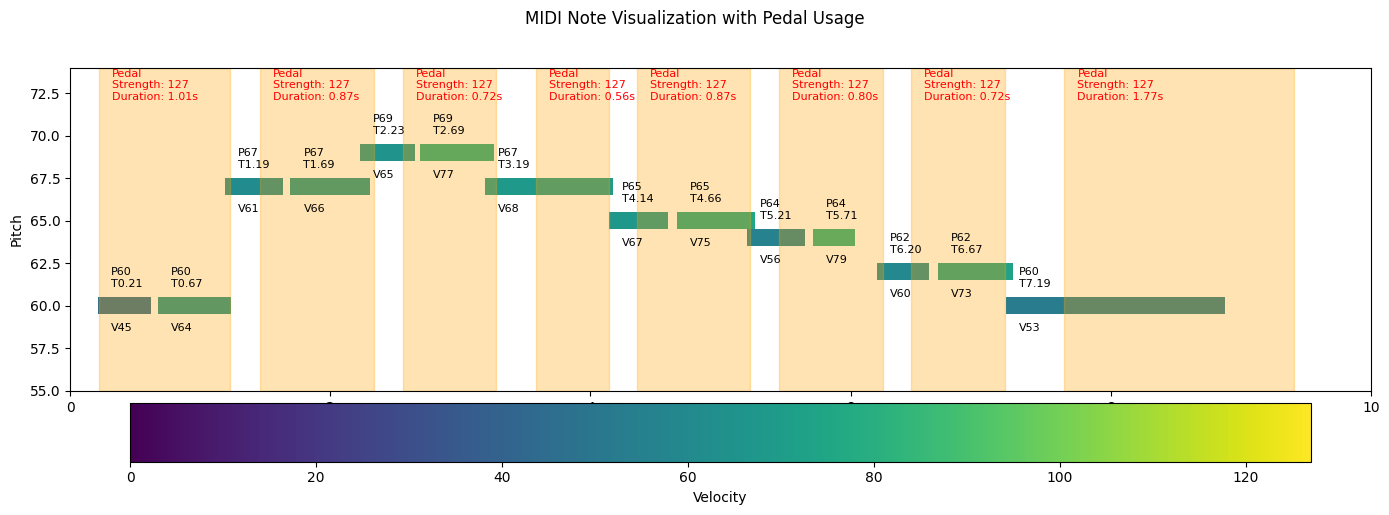

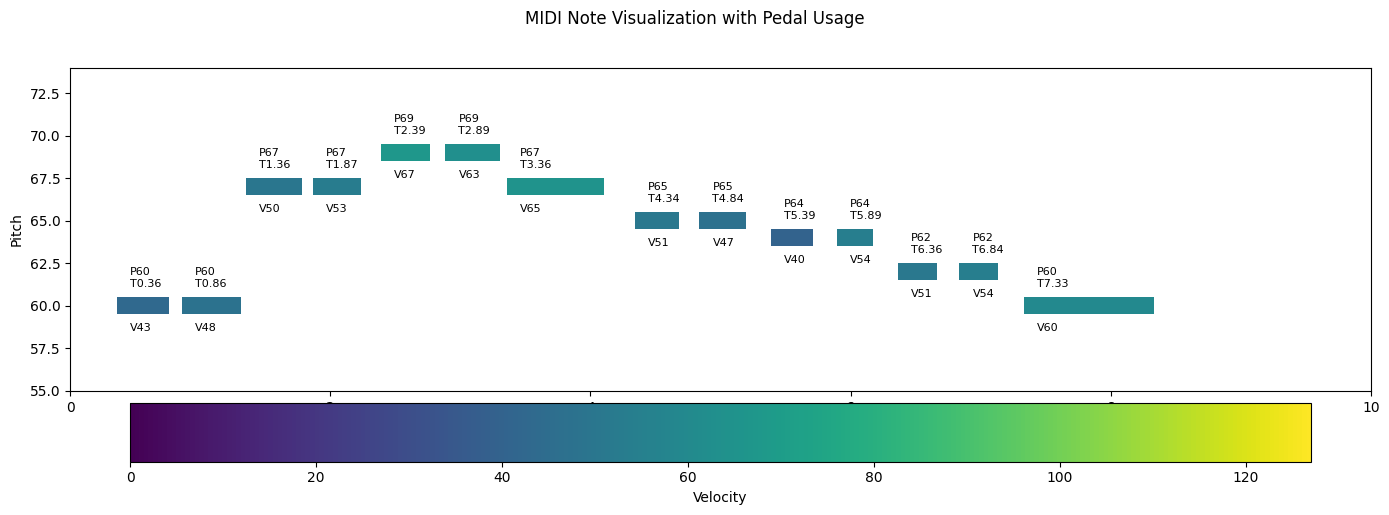

Pitch similarity: 1.00
Velocity similarity: 0.90
Duration similarity: 0.75
Pedal similarity: nan


In [13]:
import pretty_midi
import numpy as np

midi_file1 = '0_t2.mid'
midi_file2 = '0_s1.mid'

# Load the two MIDI files
midi1 = pretty_midi.PrettyMIDI(midi_file1)
midi2 = pretty_midi.PrettyMIDI(midi_file2)

# Function to extract note information (pitch, velocity, start, end) and pedal
def extract_notes_and_pedals(midi):
    notes = []
    pedals = []
    for instrument in midi.instruments:
        for note in instrument.notes:
            notes.append({
                'pitch': note.pitch,
                'velocity': note.velocity,
                'start': note.start,
                'end': note.end,
                'duration': note.end - note.start
            })
        # Extract pedal information (Control Change number 64)
        for control_change in instrument.control_changes:
            if control_change.number == 64:
                pedals.append({
                    'time': control_change.time,
                    'value': control_change.value  # Pedal down (on) if value == 127, off if value == 0
                })
    return notes, pedals

# Extract notes and pedal information from both files
notes1, pedals1 = extract_notes_and_pedals(midi1)
notes2, pedals2 = extract_notes_and_pedals(midi2)

# Function to normalize note timings by removing the offset
def normalize_notes_and_pedals(notes, pedals):
    # Get the minimum start time to align notes and pedal events
    min_start = min(note['start'] for note in notes)
    for note in notes:
        note['start'] -= min_start
        note['end'] -= min_start
    for pedal in pedals:
        pedal['time'] -= min_start
    return notes, pedals

# Normalize the notes and pedals (remove starting offset)
notes1_normalized, pedals1_normalized = normalize_notes_and_pedals(notes1, pedals1)
notes2_normalized, pedals2_normalized = normalize_notes_and_pedals(notes2, pedals2)

# Compare notes and pedal information based on velocity, duration, pitch, articulation, and pedal state
def compare_notes_and_pedals(notes1, notes2, pedals1, pedals2):
    # Ensure both note lists are sorted by start time
    notes1_sorted = sorted(notes1, key=lambda x: x['start'])
    notes2_sorted = sorted(notes2, key=lambda x: x['start'])
    
    # Sort pedals by time
    pedals1_sorted = sorted(pedals1, key=lambda x: x['time'])
    pedals2_sorted = sorted(pedals2, key=lambda x: x['time'])

    # Initialize similarity metrics
    pitch_similarity = []
    velocity_similarity = []
    duration_similarity = []
    articulation_similarity = []
    pedal_similarity = []

    # Compare note features
    for note1, note2 in zip(notes1_sorted, notes2_sorted):
        pitch_similarity.append(1 if note1['pitch'] == note2['pitch'] else 0)
        velocity_similarity.append(1 - abs(note1['velocity'] - note2['velocity']) / 127)  # Max velocity is 127
        duration_similarity.append(1 - abs(note1['duration'] - note2['duration']) / max(note1['duration'], note2['duration']))
        articulation_similarity.append(1 if (note1['duration'] / (note1['end'] - note1['start']) > 0.9) ==
                                           (note2['duration'] / (note2['end'] - note2['start']) > 0.9) else 0)

    # Compare pedal events
    for pedal1, pedal2 in zip(pedals1_sorted, pedals2_sorted):
        pedal_similarity.append(1 if pedal1['value'] == pedal2['value'] else 0)

    return {
        'pitch_similarity': np.mean(pitch_similarity),
        'velocity_similarity': np.mean(velocity_similarity),
        'duration_similarity': np.mean(duration_similarity),
        'articulation_similarity': np.mean(articulation_similarity),
        'pedal_similarity': np.mean(pedal_similarity)
    }

# Compute the similarity between the two sets of notes and pedals
similarity = compare_notes_and_pedals(notes1_normalized, notes2_normalized, pedals1_normalized, pedals2_normalized)

print("Similarity between MIDI files:")

midi_visualize(midi_file1)
midi_visualize(midi_file2)



print(f"Pitch similarity: {similarity['pitch_similarity']:.2f}")
print(f"Velocity similarity: {similarity['velocity_similarity']:.2f}")
print(f"Duration similarity: {similarity['duration_similarity']:.2f}")
# print(f"Articulation similarity: {similarity['articulation_similarity']:.2f}")
print(f"Pedal similarity: {similarity['pedal_similarity']:.2f}")